## Training the generative model supervisedly
This is the jupyter notebook to train the decoding part of the network, in an supervised manner.

In [1]:
import IPython
import custom_mnist_dataset
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
from IPython.display import HTML
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
import torch.nn as nn
import torch.optim as optim
import time
import torch.nn.functional as F

import torchvision.utils as vutils
import cv2


## Loading the training data and displaying it
We use a custom mnist dataset function to integrate the one-hot encoding to it, along with the corrupt() function to do the supervised fine-tuning.

In [2]:
batch_size = 32
mnist_data = custom_mnist_dataset.MNIST('/home/emmv1d18/Work/Databases', 
                                        train=True,
                                        transform=transforms.Compose([
                                            transforms.ToTensor(),
                                            transforms.Normalize(mean=[0.1307], std=[0.3081])]),
                                        target_transform=custom_mnist_dataset.to_one_hot(), 
                                        tuple_transform = custom_mnist_dataset.corrupt(),
                                        download=True)
data_loader = torch.utils.data.DataLoader(mnist_data,
                                          batch_size=batch_size,
                                          shuffle=True)

## Defining the different parts of the network
In the encoding part of the network, the activation function is sigmoid. The output of each layer has to be normalised to have 0 mean and one variance.
In the decoding part of the network, the activation function is linked to the visible states of the corresponding RBMs. If their state is Binary, the activation function is sigmoid. Else, no activation function is used.
One must note that the design of the encoders must be the same as the ones defined by the DBN.

In [3]:
def res(t):
    return (t-t.mean())/t.std()

In [4]:
class dbn_image(nn.Module):
    def __init__(self):
        super(dbn_image, self).__init__()
        self.conv0 = nn.Conv2d(1 , 32, 3, stride = 1)
        self.conv1 = nn.Conv2d(32, 32, 2, stride = 2)
        self.conv2 = nn.Conv2d(32, 64, 4, stride = 1)
        self.conv3 = nn.Conv2d(64, 64, 2, stride = 2)
        
    def forward(self, input):        
        batch_size = input.size()[0]
        conv0 = res(torch.sigmoid(self.conv0(input)))
        conv1 = res(torch.sigmoid(self.conv1(conv0)))
        conv2 = res(torch.sigmoid(self.conv2(conv1)))
        conv3 = torch.sigmoid(self.conv3(conv2))
        return conv3
    

In [5]:
class dbn_target(nn.Module):
    def __init__(self):
        super(dbn_target, self).__init__()
        self.conv0 = nn.Conv2d(1 , 16, (4,1), stride = 1)
        self.conv1 = nn.Conv2d(16, 32, (3,1), stride = 1)
    
    def forward(self, input):      
        conv0 = res(torch.sigmoid(self.conv0(input)))
        conv1 = res(torch.sigmoid(self.conv1(conv0)))
        return conv1
  

In [6]:
class joint(nn.Module):
    def __init__(self):
        super(joint, self).__init__()
        self.conv0 = nn.Conv2d(64,64,5)
        self.conv1 = nn.Conv2d(32,64,(5,1), bias =False)
        
    def forward(self, img, tgt):
        h0 = self.conv0(img)
        h1 = self.conv1(tgt)
        return torch.sigmoid(h0+h1)
    

In [7]:
class gen_image(nn.Module):
    def __init__(self):
        super(gen_image, self).__init__()
        self.conv0 = nn.ConvTranspose2d(64, 64, 5, stride = 1) 
        self.conv1 = nn.ConvTranspose2d(64, 64, 2, stride = 2) 
        self.conv2 = nn.ConvTranspose2d(64, 32, 4, stride = 1)
        self.conv3 = nn.ConvTranspose2d(32, 32, 2, stride = 2) 
        self.conv4 = nn.ConvTranspose2d(32, 1 , 3, stride = 1)
        
    def forward(self, input):        
        conv0 = res(self.conv0(input))
        conv1 = res(self.conv1(conv0))
        conv2 = res(self.conv2(conv1))
        conv3 = res(self.conv3(conv2))
        conv4 = res(self.conv4(conv3))
        return conv4

In [8]:
class gen_target(nn.Module):
    def __init__(self):
        super(gen_target, self).__init__()
        self.conv0 = nn.ConvTranspose2d(64, 32, (5,1), stride = 1) 
        self.conv1 = nn.ConvTranspose2d(32, 16, (3,1), stride = 1) 
        self.conv2 = nn.ConvTranspose2d(16, 1 , (4,1), stride = 1)
        
    def forward(self, input):        
        conv0 = res(self.conv0(input))
        conv1 = res(self.conv1(conv0))
        conv2 = torch.sigmoid(self.conv2(conv1))
        return conv2

## Initialising the parts of the network
Here, we retrieve the parameters of each layer from the saved RBM's parameters.

In [9]:
def initialise_img_dbn(dbn):
    rbm_0 = torch.load('./saves_mnist_demo/rbm0_img_3x3x1x32')
    rbm_1 = torch.load('./saves_mnist_demo/rbm1_img_2x2x2x32')
    rbm_2 = torch.load('./saves_mnist_demo/rbm2_img_4x4x1x64')
    rbm_3 = torch.load('./saves_mnist_demo/rbm3_img_2x2x2x64')
    dbn.state_dict()['conv0.weight'].data.copy_(rbm_0['weights'])
    dbn.state_dict()['conv0.bias'].data.copy_(rbm_0['h_bias'])
    dbn.state_dict()['conv1.weight'].data.copy_(rbm_1['weights'])
    dbn.state_dict()['conv1.bias'].data.copy_(rbm_1['h_bias'])
    dbn.state_dict()['conv2.weight'].data.copy_(rbm_2['weights'])
    dbn.state_dict()['conv2.bias'].data.copy_(rbm_2['h_bias'])
    dbn.state_dict()['conv3.weight'].data.copy_(rbm_3['weights'])
    dbn.state_dict()['conv3.bias'].data.copy_(rbm_3['h_bias'])

In [10]:
def initialise_tgt_dbn(dbn):
    rbm_0 = torch.load('./saves_mnist_demo/rbm0_tgt_4x1x1x16')
    rbm_1 = torch.load('./saves_mnist_demo/rbm1_tgt_3x1x1x32')
    dbn.state_dict()['conv0.weight'].data.copy_(rbm_0['weights'])
    dbn.state_dict()['conv0.bias'].data.copy_(rbm_0['h_bias'])
    dbn.state_dict()['conv1.weight'].data.copy_(rbm_1['weights'])
    dbn.state_dict()['conv1.bias'].data.copy_(rbm_1['h_bias'])

In [11]:
def initialise_joint(joint):
    model = torch.load('./saves_mnist_demo/joint')
    joint.state_dict()['conv0.weight'].data.copy_(model['0']['weights'])
    joint.state_dict()['conv0.bias'].data.copy_(model['h_bias'])
    joint.state_dict()['conv1.weight'].data.copy_(model['1']['weights'])


In [12]:
def initialise_img_gen(dbn):
    rbm_0 = torch.load('./saves_mnist_demo/rbm0_img_3x3x1x32')
    rbm_1 = torch.load('./saves_mnist_demo/rbm1_img_2x2x2x32')
    rbm_2 = torch.load('./saves_mnist_demo/rbm2_img_4x4x1x64')
    rbm_3 = torch.load('./saves_mnist_demo/rbm3_img_2x2x2x64')
    model = torch.load('./saves_mnist_demo/joint')
    dbn.state_dict()['conv0.weight'].data.copy_(model['0']['weights'])
    dbn.state_dict()['conv0.bias'].data.copy_(model['0']['v_bias'])
    dbn.state_dict()['conv1.weight'].data.copy_(rbm_3['weights'])
    dbn.state_dict()['conv1.bias'].data.copy_(rbm_3['v_bias'])
    dbn.state_dict()['conv2.weight'].data.copy_(rbm_2['weights'])
    dbn.state_dict()['conv2.bias'].data.copy_(rbm_2['v_bias'])
    dbn.state_dict()['conv3.weight'].data.copy_(rbm_1['weights'])
    dbn.state_dict()['conv3.bias'].data.copy_(rbm_1['v_bias'])
    dbn.state_dict()['conv4.weight'].data.copy_(rbm_0['weights'])
    dbn.state_dict()['conv4.bias'].data.copy_(rbm_0['v_bias'])


In [13]:
def initialise_tgt_gen(dbn):
    rbm_0 = torch.load('./saves_mnist_demo/rbm0_tgt_4x1x1x16')
    rbm_1 = torch.load('./saves_mnist_demo/rbm1_tgt_3x1x1x32')
    model = torch.load('./saves_mnist_demo/joint')
    dbn.state_dict()['conv0.weight'].data.copy_(model['1']['weights'])
    dbn.state_dict()['conv0.bias'].data.copy_(model['1']['v_bias'])
    dbn.state_dict()['conv1.weight'].data.copy_(rbm_1['weights'])
    dbn.state_dict()['conv1.bias'].data.copy_(rbm_1['v_bias'])
    dbn.state_dict()['conv2.weight'].data.copy_(rbm_0['weights'])
    dbn.state_dict()['conv2.bias'].data.copy_(rbm_0['v_bias'])

## Instanciation and initialisation of the different parts of the network
If the encoder has just been trained unsupervisedly, the previously defined initialisation functions have to be called now. 
Otherwise, one can load the parameters of each layer from a saved .pth file.

In [34]:
img_modality = dbn_image()
tgt_modality = dbn_target()
joint_layer  = joint()
img_generator = gen_image()
tgt_generator = gen_target()

'''
initialise_img_dbn(img_modality)
initialise_tgt_dbn(tgt_modality)
initialise_joint(joint_layer)
initialise_img_gen(img_generator)
initialise_tgt_gen(tgt_generator)
'''

img_modality.load_state_dict(torch.load('./saves_mnist_demo/image_modality.pth'))
tgt_modality.load_state_dict(torch.load('./saves_mnist_demo/target_modality.pth'))
joint_layer.load_state_dict(torch.load('./saves_mnist_demo/joint_layer.pth'))
img_generator.load_state_dict(torch.load('./saves_mnist_demo/image_generator.pth'))
tgt_generator.load_state_dict(torch.load('./saves_mnist_demo/target_generator.pth'))

# The different networks are then sorted between the different available GPUs.
img_modality.to(0)
tgt_modality.to(1)
joint_layer.to('cpu')
img_generator.to(0)
tgt_generator.to(1)

gen_target(
  (conv0): ConvTranspose2d(64, 32, kernel_size=(5, 1), stride=(1, 1))
  (conv1): ConvTranspose2d(32, 16, kernel_size=(3, 1), stride=(1, 1))
  (conv2): ConvTranspose2d(16, 1, kernel_size=(4, 1), stride=(1, 1))
)

## Training of the network
Uncomment the following cell to perform the training of the whole network.

## Random digits generation
Once the network is optimised, it can be used to generate random numbers.
Given a one-hot vector encoding the number to be generated on the target modality and a zero-input on the image modality.
In this demo, the encoding on a joint-layer of such an input is unique. To one one-hot encoding corresponds one encoding on h. It is then not sufficient to generate different digits. The trick is to add noise to the encoding, as done hereafter.

In [59]:
data =next(iter(data_loader))
tgt = data['target_ref']
img = torch.zeros((batch_size,1,28,28)).cuda(device=0)
h = joint_layer(img_modality(img).detach().cpu(), tgt_modality(tgt.cuda(device =1)).detach().cpu())
noise = torch.rand((batch_size,64,1,1))*0.1
x_n = img_generator((h+noise).cuda(device = 0))
x = img_generator((h).cuda(device = 0))

In [60]:
h_ = h.detach().cpu().view(batch_size,8,8)
h_n = (h+noise).detach().cpu().view(batch_size,8,8)
x_  = x.detach().cpu().view(batch_size,1,28,28)
x_n_ = x_n.detach().cpu().view(batch_size,1,28,28)


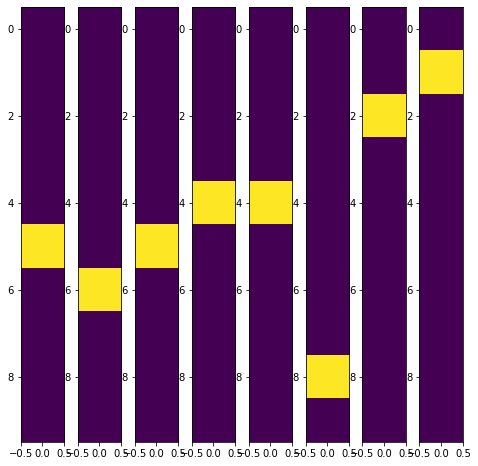

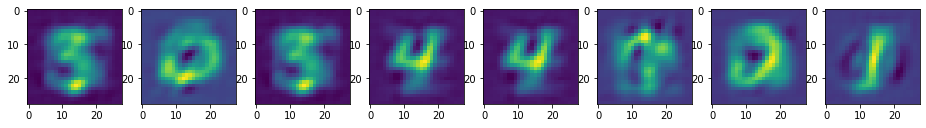

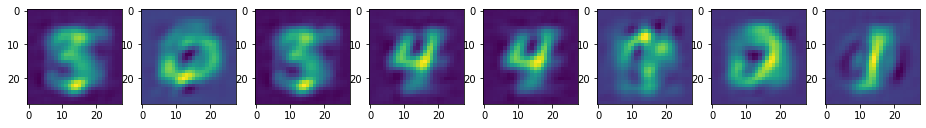

In [61]:
columns = 8
rows = 1
fig=plt.figure(figsize=(8, 8))
for i in range(1, (columns*rows)+1 ):
    fig.add_subplot(rows, columns, i)
    plt.imshow(tgt[i][0])
plt.show()
f_s = 16
fig=plt.figure(figsize=(f_s, f_s))
for i in range(1, (columns*rows)+1 ):
    fig.add_subplot(rows, columns, i)
    plt.imshow(x_[i][0])
plt.show()

fig=plt.figure(figsize=(f_s, f_s))
for i in range(1, (columns*rows)+1 ):
    fig.add_subplot(rows, columns, i)
    plt.imshow(x_n_[i][0])
plt.show()